In this step, we prepare our development environment by installing and importing the necessary libraries. TensorFlow and TensorFlow Hub will be our main frameworks, with TensorFlow Hub providing access to pre-trained BERT models. TensorFlow Text provides text preprocessing utilities specifically designed for BERT models.

In [1]:
# Install TensorFlow and TensorFlow Hub
!pip install tensorflow tensorflow-hub tensorflow-text

In [3]:
import os
# Need to run to make latest TF version work with TF hub
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

The libraries we're importing serve specific purposes:

tensorflow is our core ML framework
tensorflow_hub provides access to pre-trained models
tensorflow_text handles text preprocessing for BERT
numpy provides numerical computing functionality
matplotlib.pyplot will help us visualize training results
train_test_split from scikit-learn will help create validation sets

Data quality is crucial for successful fine-tuning. In this step, we load the IMDB movie reviews dataset, which contains labeled movie reviews as either positive (1) or negative (0). We need to convert these reviews from their encoded format back to text, which BERT can process.

In [4]:
# Load the IMDB dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

# Get word index mapping
word_index = tf.keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

# Reverse word index to convert numbers back to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Function to decode reviews back to text
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# Convert indices back to text
train_texts = [decode_review(review) for review in x_train]
test_texts = [decode_review(review) for review in x_test]

# Labels good as is (arrays)
train_labels = y_train
test_labels = y_test

This code does several important things:

It loads the IMDB dataset where reviews are encoded as sequences of word indices
It retrieves the word index mapping and adds special tokens
It creates a reverse mapping to convert indices back to words
It defines a function to decode reviews from numerical format back to text
It applies this function to convert all reviews to text format

In [5]:
# Create validation set from training data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

print(f"Training examples: {len(train_texts)}")
print(f"Validation examples: {len(val_texts)}")
print(f"Testing examples: {len(test_texts)}")

Training examples: 20000
Validation examples: 5000
Testing examples: 25000


Creating a validation set is crucial for monitoring model performance during training and preventing overfitting. We split 20% of the training data to serve as a validation set, using a fixed random seed (42) to ensure reproducibility.

This step involves two critical decisions: selecting an appropriate pre-trained BERT model and setting up efficient data pipelines. The choice of model balances accuracy with computational requirements.

In [6]:
# Select a smaller BERT model for faster fine-tuning
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

# Load preprocessing model and BERT model from TensorFlow Hub
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}
map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f"BERT model selected: {tfhub_handle_encoder}")
print(f"Preprocessing model: {tfhub_handle_preprocess}")

BERT model selected: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocessing model: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Here we're selecting a smaller BERT variant with 4 layers, 512 hidden dimensions, and 8 attention heads. This provides a good balance between performance and speed for our sentiment analysis task. Each BERT model requires a specific preprocessing model that handles tokenization in a consistent way, so we load both from TensorFlow Hub.

The notation "L-4_H-512_A-8" tells us:

L-4: 4 transformer layers (compared to 12 in BERT-base)
H-512: 512-dimensional hidden states (compared to 768 in BERT-base)
A-8: 8 attention heads (compared to 12 in BERT-base)
Create a function to convert text to TensorFlow datasets:

In [7]:
# Create TensorFlow datasets
def create_dataset(texts, labels, batch_size=32, shuffle=True):
   dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
   if shuffle:
       dataset = dataset.shuffle(len(texts))
   dataset = dataset.batch(batch_size)
   dataset = dataset.prefetch(tf.data.AUTOTUNE)
   return dataset


# Create train, validation, and test datasets
train_dataset = create_dataset(train_texts, train_labels)
val_dataset = create_dataset(val_texts, val_labels)
test_dataset = create_dataset(test_texts, y_test, shuffle=False)

 Efficient data loading is crucial for training performance. The create_dataset function performs several optimizations:

Creates a TensorFlow Dataset from text and labels
Shuffles data to prevent learning order-specific patterns
Batches examples for parallel processing (32 examples per batch)
Enables prefetching to overlap preprocessing and model execution
Important to NOT shuffle the testing data for accurate evaluation
These optimizations ensure that data loading doesn't become a bottleneck during training with tensorflow.

In this step, we design the model architecture by combining the pre-trained BERT model with task-specific layers for sentiment classification. BERT handles the text understanding, while our added layers adapt that understanding to our specific task.

In [8]:
def build_classifier_model():
   # Text input
   text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  
   # Preprocessing layer (tokenization, etc.)
   preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
   encoder_inputs = preprocessing_layer(text_input)
  
   # BERT encoder
   encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
   # For time sake we will set the BERT parameters to not be trained and only optimize the dense layer weights from the classification head
   outputs = encoder(encoder_inputs)
  
   # Use the pooled output for sequence classification
   net = outputs['pooled_output']
  
   # Add dropout for regularization
   net = tf.keras.layers.Dropout(0.1)(net)
  
   # Add classification layer (binary for sentiment)
   net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  
   # Create model
   model = tf.keras.Model(text_input, net)
   return model


classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

This function defines our model architecture with the following components:

Text Input Layer: Accepts raw text strings
Preprocessing Layer: Handles tokenization, adding special tokens, and creating attention masks
BERT Encoder: The pre-trained BERT model that converts tokens to contextual embeddings
Pooled Output: We use the special [CLS] token representation, which BERT provides as the 'pooled_output'
Dropout Layer: Prevents overfitting by randomly zeroing 10% of activations during training
Classification Layer: A single neuron dense layer for binary sentiment prediction with sigmoid activation
Setting trainable=False for the BERT encoder prevents its weights from being updated during fine-tuning, enabling the model to solely adapt the weights in its classification head, reducing training time needed. Training the encoder weights can help the model learn the specific task but requires larges amounts of time and computation and risks overfitting by changing the pre-trained weights too much.

The model.summary() call displays the architecture and shows the number of parameters in each layer. Most parameters are in the BERT encoder itself.

This step involves configuring and executing the training process. Fine-tuning requires careful selection of hyperparameters to effectively adapt the pre-trained BERT model to our specific task without destroying its valuable pre-trained knowledge.

In [9]:
# Set up loss and metrics
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy('accuracy')]

# Set up learning rate and optimizer
init_lr = .0005
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=init_lr)

# Compile the model
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Set up callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True)

The configuration includes several critical components:

Loss Function: We use binary cross-entropy with from_logits=True since our model outputs raw logits rather than probabilities
Metrics: Binary accuracy tracks the percentage of correctly classified examples
Learning Rate: A small learning rate (3e-5) prevents catastrophic forgetting of pre-trained knowledge
Optimizer: Adam combines advantages of AdaGrad and RMSProp optimizers with momentum
Early Stopping: Prevents overfitting by stopping training when validation accuracy stops improving
The small learning rate is particularly important for fine-tuning pre-trained models - too large a value would destroy the valuable information already in the weights.

Train the model:

In [10]:
print('Fine-tuning BERT model...')
history = classifier_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stopping])

Fine-tuning BERT model...
Epoch 1/5
625/625 [==============================] - 55s 85ms/step - loss: 0.6259 - accuracy: 0.6445 - val_loss: 0.5604 - val_accuracy: 0.7178
Epoch 2/5
625/625 [==============================] - 54s 87ms/step - loss: 0.5511 - accuracy: 0.7207 - val_loss: 0.5298 - val_accuracy: 0.7412
Epoch 3/5
625/625 [==============================] - 55s 88ms/step - loss: 0.5335 - accuracy: 0.7347 - val_loss: 0.5202 - val_accuracy: 0.7470
Epoch 4/5
625/625 [==============================] - 55s 88ms/step - loss: 0.5253 - accuracy: 0.7395 - val_loss: 0.5124 - val_accuracy: 0.7474
Epoch 5/5
625/625 [==============================] - 55s 88ms/step - loss: 0.5204 - accuracy: 0.7421 - val_loss: 0.5118 - val_accuracy: 0.7468


The training process:

Feeds batches of data through the model
Computes loss based on model predictions vs. true labels
Updates model weights to reduce the loss
Validates performance on the validation set after each epoch
Stores training metrics in the history object
May stop early if validation performance plateaus
We limit training to 50 epochs since fine-tuning typically requires fewer epochs than training from scratch.

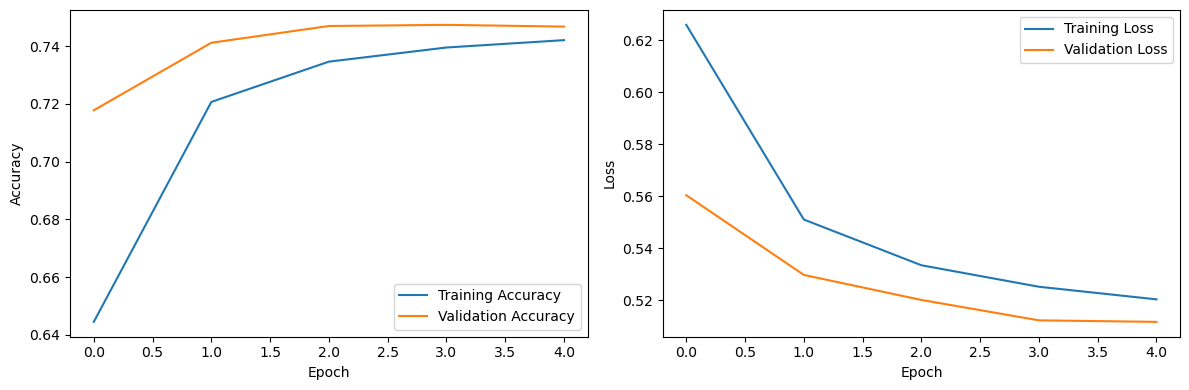

In [11]:
# Plot training metrics
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

Visualization is crucial for understanding the training dynamics:

Rising accuracy and falling loss indicate learning is occurring
Diverging training and validation metrics suggest overfitting
Validation metrics plateauing indicate diminishing returns from continued training
These plots help us diagnose training issues and determine if the model needs further tuning. In our case it looks like 5 epochs was not enough as the model is clearly still learning!

In [12]:
# Evaluate the model on test data
loss, accuracy = classifier_model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.3f}')

782/782 [==============================] - 50s 64ms/step - loss: 0.5079 - accuracy: 0.7484
Test accuracy: 0.748


The evaluation process:

Runs the entire test dataset through the model
Computes the same loss and metrics defined during compilation
Returns averaged values across all test examples
Test accuracy gives us an unbiased estimate of how well our model will perform on new, unseen reviews. Unlike validation accuracy (which we used during training), test accuracy isn't influenced by our hyperparameter decisions since the test data wasn't used in the training process. We can take this further by looking at even more metrics, including the familiar confusion matrix and classification report.

782/782 [==============================] - 50s 63ms/step


<Figure size 1000x800 with 0 Axes>

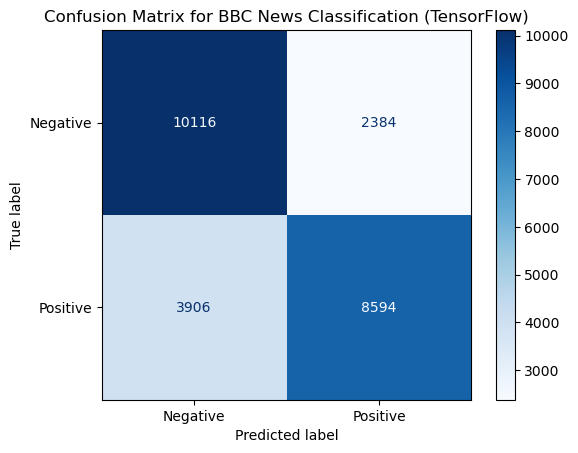


Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.81      0.76     12500
    Positive       0.78      0.69      0.73     12500

    accuracy                           0.75     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.75      0.75      0.75     25000



In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# Generate predictions for the test set
test_predictions = classifier_model.predict(test_dataset)
# Model predicts probability of class 1 via sigmoid output layer
y_pred = [1 if pred >= 0.5 else 0 for pred in test_predictions]


# Get true labels
y_true = [labels.numpy() for _, labels in test_dataset.unbatch()]


# Create and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (TensorFlow)')
plt.grid(False)
plt.show()


# Create classification report
report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'], output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

In [14]:
# Create a function for model inference on new articles
def predict_sentiment(text, model=classifier_model):
   """
   Predict the category of a news article using the fine-tuned model.
  
   Args:
       text (str): The text of the news article
       model: The fine-tuned TensorFlow model
      
   Returns:
       dict: Prediction results including category and confidence scores
   """
   # Make prediction
   prediction = model.predict([text])[0][0]
  
   # Get the predicted sentiment and confidence
   predicted_sentiment = "Postive" if prediction >= 0.5 else "Negative"
   confidence = float(prediction)
  
   return {
       'text': text[:100] + '...' if len(text) > 100 else text,
       'predicted_sentiment': predicted_sentiment,
       'confidence': confidence
   }
  
# Test the prediction function
sample_text = "This movie was excellent! The acting was stellar."
predictions = predict_sentiment(sample_text)
print(f"Text: {predictions['text']}")
print(f"Sentiment: {predictions['predicted_sentiment']} ({predictions['confidence']:.4f})")

1/1 [==============================] - 0s 387ms/step
Text: This movie was excellent! The acting was stellar.
Sentiment: Postive (0.5206)


This function handles the prediction workflow:

Accepts a single text string
Passes the text through our model to get probabilities
Classifies as positive or negative based on a 0.5 threshold
Returns structured prediction results including text, probability/confidence, and sentiment label
The function makes our model usable in practical applications by handling the input/output formatting and probability conversion. It can be easily integrated into larger systems like web applications or data processing pipelines.

The final step in our process is to save the trained model so it can be deployed in production environments. Proper model saving ensures that we can use our fine-tuned BERT model without retraining.

In [15]:
# Save the model
model_save_path = "./bert_sentiment_model_tf"
classifier_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

INFO:tensorflow:Assets written to: ./bert_sentiment_model_tf\assets


INFO:tensorflow:Assets written to: ./bert_sentiment_model_tf\assets


Model saved to ./bert_sentiment_model_tf


This command saves several components:

The model architecture (network structure)
The model weights (learned parameters)
The training configuration (optimizer, loss, etc.)
The state of all variables (if any)
The saved model can be loaded later with tf.keras.models.load_model() and used for inference without needing access to the original code. The format is compatible with TensorFlow Serving, TensorFlow Lite, and other deployment tools.

The saved model includes both the BERT model and our custom classification layer, so it's ready to make predictions on new text inputs. This is crucial for moving from experimentation to production, where the model might be deployed in a web service, mobile app, or batch processing system.